## 기술적 분석
가격과 거래량을 이용하여 미래의 주가 방향을 예측하고자 하는 증권 분석 방법론이다.
역사적 주가 정보는 웹에서 구하고 주가 추세 신호에 따른 트레이딩 시스템을 간단히 백테스팅하는 코드 구현


In [3]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
#pandas.io.data 가 pandas_datareader로 바뀐 듯,,,

In [4]:
sp500 = web.DataReader('^GSPC', data_source='yahoo',
                        start='1/1/2000', end='4/14/2014')
sp500.info

<bound method DataFrame.info of                    High          Low         Open        Close      Volume  \
Date                                                                         
1999-12-31  1472.420044  1458.189941  1464.469971  1469.250000   374050000   
2000-01-03  1478.000000  1438.359985  1469.250000  1455.219971   931800000   
2000-01-04  1455.219971  1397.430054  1455.219971  1399.420044  1009000000   
2000-01-05  1413.270020  1377.680054  1399.420044  1402.109985  1085500000   
2000-01-06  1411.900024  1392.099976  1402.109985  1403.449951  1092300000   
...                 ...          ...          ...          ...         ...   
2014-04-08  1854.949951  1837.489990  1845.479980  1851.959961  3721450000   
2014-04-09  1872.430054  1852.380005  1852.640015  1872.180054  3308650000   
2014-04-10  1872.530029  1830.869995  1872.280029  1833.079956  3758780000   
2014-04-11  1835.069946  1814.359985  1830.650024  1815.689941  3743460000   
2014-04-14  1834.189941  1815.80

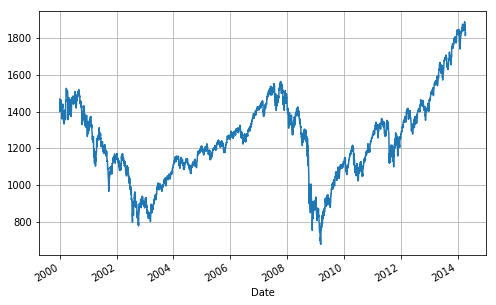

In [5]:
sp500['Close'].plot(grid=True, figsize=(8, 5))

### 구현하고자하는 추세 전략
: 2개월(42 거래일)과 1년(252 거래일) 추세(지수의 해당 주기 이동평균)에 기반하여 매매 신호 규칙 생성하기

In [8]:
# pandas를 이용하여 추세 시계열 생성하기
sp500['42d'] = np.round(sp500['Close'].rolling(42).mean(), 2)
sp500['252d'] = np.round(sp500['Close'].rolling(252).mean(), 2)
sp500[['Close', '42d', '252d']].tail()

,Close,42d,252d
Date,,,
2014-04-08,1851.959961,1853.88,1728.66
2014-04-09,1872.180054,1855.67,1729.79
2014-04-10,1833.079956,1856.46,1730.74
2014-04-11,1815.689941,1856.36,1731.64
2014-04-14,1830.609985,1856.63,1732.74


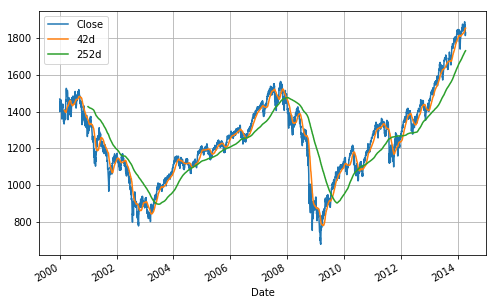

In [9]:
sp500[['Close','42d','252d']].plot(grid=True, figsize=(8,5))

### 매매 신호 규칙 생성
**매수 신호(주식 매수)**  
  42일 추세가 252일 추세보다 SD(Signal Treshold) 값만큼 위에 도달하였을 때 
  
**대기 신호(현금 보유)**  
  42일 추세가 252일 추세의 위 아래 SD 값 사이에 있을 때  
  
**매도 신호(주식 공매도)**  
  42일 추세가 252일 추세보다 SD 값만큼 아래에 도달하였을 때

In [13]:
# 신호 값을 수치화 해서 분석하기
sp500['42-252'] = sp500['42d'] - sp500['252d']
sp500['42-252'].tail()


Date
2014-04-08    125.22
2014-04-09    125.88
2014-04-10    125.72
2014-04-11    124.72
2014-04-14    123.89
Name: 42-252, dtype: float64

In [14]:
# 매매 구간 정보를 기록할 열을 추가한다. 신호 임계값(SD)을 50으로 가정
SD=50
sp500['Regime'] = np.where(sp500['42-252'] > SD, 1, 0)
sp500['Regime'] = np.where(sp500['42-252'] < -SD, -1, sp500['Regime'])
sp500['Regime'].value_counts()

 1    1489
 0    1232
-1     872
Name: Regime, dtype: int64

(-1.1, 1.1)

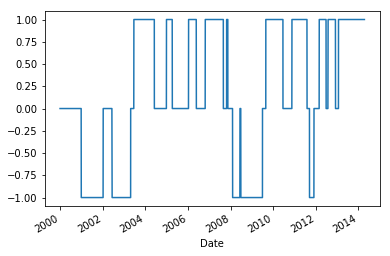

In [18]:
# 신호 시각화
import matplotlib.pyplot as plt
sp500['Regime'].plot(lw=1.5)
plt.ylim([-1.1, 1.1])

### 투자 전략 백테스팅 구현하기

In [19]:
# 시장수익률 계산 
sp500['Market'] = np.log(sp500['Close'] / sp500['Close'].shift(1))

In [20]:
# 추세 기반 매매 전략의 수익률 계산
# = 매매영역 열의 자료를 하루 지연시키고 시장 수익률과 곱하면 된다.
sp500['Strategy'] = sp500['Regime'].shift(1) * sp500['Market']

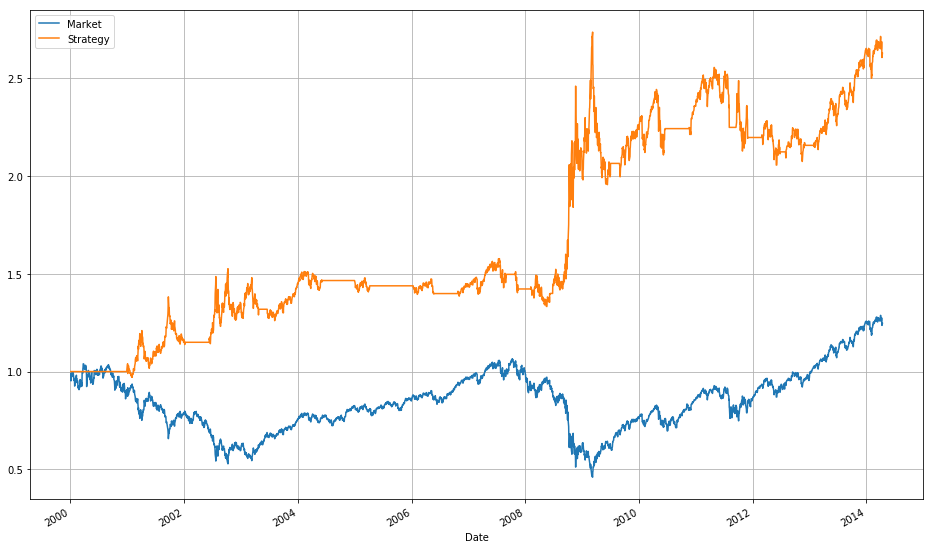

In [21]:
# 시장수익률과의 비교
sp500[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True, figsize=(16, 10))

### 결과 분석
2008 2009년 시장 하락기에는 공매도를 통해 수익을 올리고 있다는 것을 알 수 있음.  
시장 상승기에 모든 기회를 포착하지는 못하지만 전체적으로 시장 수익률을 상회하고 있다.  
다만 이 결과는 실제 매매 시 발생할 이슈와 거래 비용같은 요소를 모두 무시하고 있음.